In [1]:
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, LayerNormalization, Activation, Bidirectional, SimpleRNN
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import zscore
from keras.layers import Activation
from keras import backend as K
import tensorflow as tf
from sklearn.model_selection import ParameterGrid
from keras.regularizers import l2
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Load the dataset
data = pd.read_csv("energydata_complete.csv")

# Data Preprocessing
# Convert date column to datetime with the correct format
data['date'] = pd.to_datetime(data['date'], format="%d-%m-%Y %H:%M")

# Create new target feature 'total_usage'
data['total_usage'] = data['Appliances'] + data['lights']
data = data.drop(columns=['Appliances', 'lights'])


# Fill NaN values generated 
data.fillna(method='bfill', inplace=True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18144\1804641507.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


C:\Users\Administrator\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Administrator\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


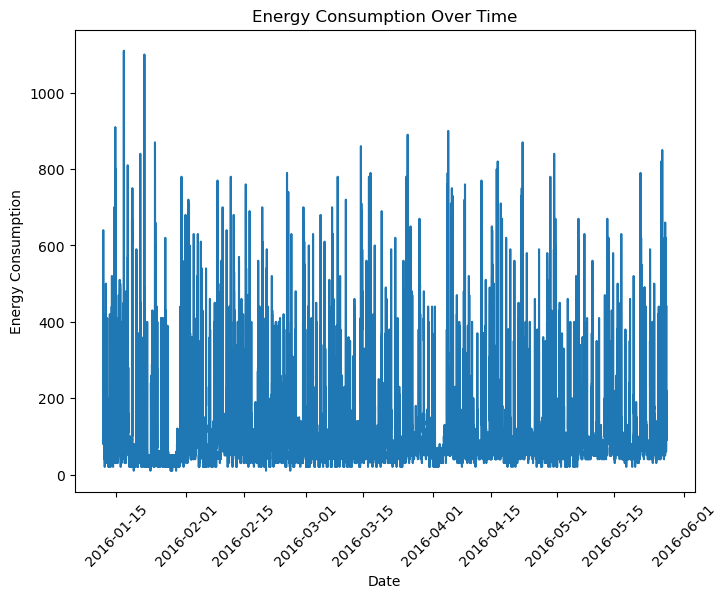

In [3]:
# Visualizations
plt.figure(figsize=(8, 6))
sns.lineplot(x='date', y='total_usage', data=data)
plt.title('Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.xticks(rotation=45)
plt.show()

In [4]:
# Calculate correlations
correlations = data.corr()

# Extract correlations with the target variable
target_correlations = correlations['total_usage']

# Display correlations
print("Correlations with the target variable (energy consumption):")
print(target_correlations)

Correlations with the target variable (energy consumption):
date          -0.023892
T1             0.052673
RH_1           0.092634
T2             0.117511
RH_2          -0.055513
T3             0.076143
RH_3           0.045618
T4             0.038891
RH_4           0.025402
T5             0.013422
RH_5           0.017569
T6             0.109538
RH_6          -0.070009
T7             0.015052
RH_7          -0.051987
T8             0.033436
RH_8          -0.091385
T9            -0.002149
RH_9          -0.051213
T_out          0.091733
Press_mm_hg   -0.035069
RH_out        -0.144363
Windspeed      0.090156
Visibility     0.001750
Tdewpoint      0.012321
rv1           -0.010907
rv2           -0.010907
total_usage    1.000000
Name: total_usage, dtype: float64


Selected features based on correlation analysis:
['RH_1', 'T2', 'T3', 'T6', 'RH_6', 'RH_8', 'T_out', 'RH_out', 'Windspeed']


C:\Users\Administrator\AppData\Local\Temp\ipykernel_18144\2691739377.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18144\2691739377.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['total_usage_1w'] = data_cleaned['total_usage'].shift(-7*24)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18144\2691739377.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

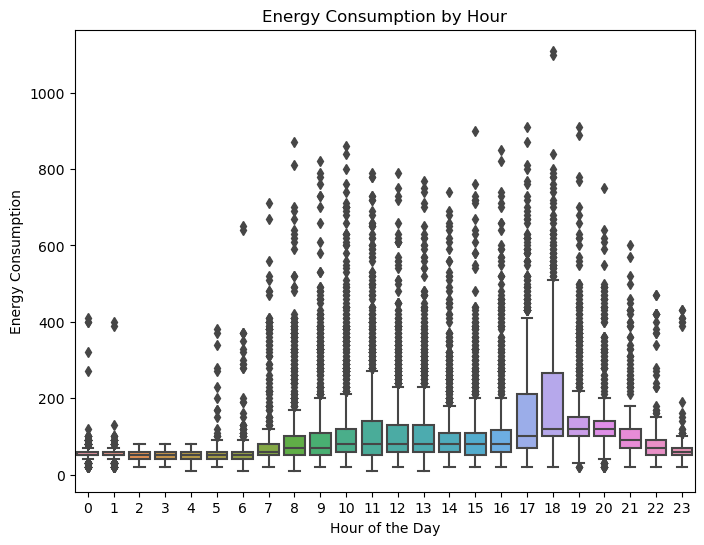

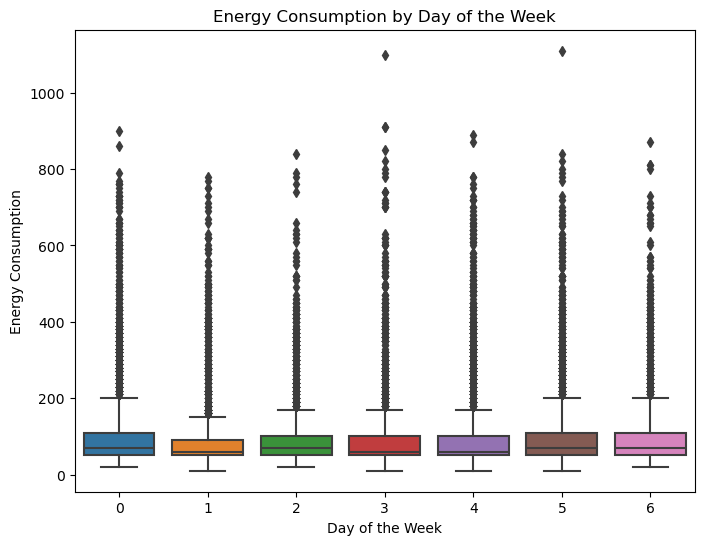

In [5]:
# Select features with high correlation to total_usage
selected_features = target_correlations[abs(target_correlations) > 0.07].index.tolist()
selected_features.remove('total_usage')  # Remove the target itself

print("Selected features based on correlation analysis:")
print(selected_features)

# Feature Engineering
data['hour'] = data['date'].dt.hour
data['day_of_week'] = data['date'].dt.dayofweek
data['rolling_mean_24'] = data['total_usage'].rolling(window=24).mean()
data['rolling_std_24'] = data['total_usage'].rolling(window=24).std()
data['lag_1'] = data['total_usage'].shift(1)
data['lag_24'] = data['total_usage'].shift(24)
data['hour_day_interaction'] = data['hour'] * data['day_of_week']

# Add only selected features to the final dataset
features = selected_features + ['hour', 'day_of_week', 'rolling_mean_24', 'rolling_std_24', 'lag_1', 'lag_24', 'hour_day_interaction']

# Fill NaN values generated by rolling and lag features
data.fillna(method='bfill', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data.drop(columns=['date'])), columns=data.columns[1:])

# Remove outliers from each feature
data_cleaned = data_normalized[(np.abs(zscore(data_normalized)) < 3).all(axis=1)]

# Create prediction windows
data_cleaned['total_usage_1w'] = data_cleaned['total_usage'].shift(-7*24)
data_cleaned['total_usage_4w'] = data_cleaned['total_usage'].shift(-4*7*24)
data_cleaned['total_usage_12w'] = data_cleaned['total_usage'].shift(-12*7*24)

# Drop rows with NaN values generated by shifting
data_cleaned.dropna(inplace=True)

# Split into features and target for each prediction window
def prepare_data(window):
    X = data_cleaned.drop(columns=['total_usage_1w', 'total_usage_4w', 'total_usage_12w', 'total_usage'])
    y = data_cleaned[f'total_usage_{window}']
    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train_1w, X_test_1w, y_train_1w, y_test_1w = prepare_data('1w')
X_train_4w, X_test_4w, y_train_4w, y_test_4w = prepare_data('4w')
X_train_12w, X_test_12w, y_train_12w, y_test_12w = prepare_data('12w')

# Reshape the training and testing data for LSTM
n_timesteps = 1  # You can experiment with different values
X_train_lstm_1w = X_train_1w.values.reshape((X_train_1w.shape[0], n_timesteps, X_train_1w.shape[1]))
X_test_lstm_1w = X_test_1w.values.reshape((X_test_1w.shape[0], n_timesteps, X_test_1w.shape[1]))
X_train_lstm_4w = X_train_4w.values.reshape((X_train_4w.shape[0], n_timesteps, X_train_4w.shape[1]))
X_test_lstm_4w = X_test_4w.values.reshape((X_test_4w.shape[0], n_timesteps, X_test_4w.shape[1]))
X_train_lstm_12w = X_train_12w.values.reshape((X_train_12w.shape[0], n_timesteps, X_train_12w.shape[1]))
X_test_lstm_12w = X_test_12w.values.reshape((X_test_12w.shape[0], n_timesteps, X_test_12w.shape[1]))

plt.figure(figsize=(8, 6))
sns.boxplot(x='hour', y='total_usage', data=data)
plt.title('Energy Consumption by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Consumption')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='day_of_week', y='total_usage', data=data)
plt.title('Energy Consumption by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Energy Consumption')
plt.show()


In [6]:
# Model Architecture - LSTM-GRU


def swish(x):
    return x * tf.sigmoid(x)


# Define the LSTM-GRU model
def create_model():
    model = Sequential([
        Bidirectional(LSTM(512, return_sequences=True, activation='sigmoid')),
        LayerNormalization(),
        Dropout(0.1),
        LSTM(256, return_sequences=True, activation='tanh'),
        LayerNormalization(),
        Dropout(0.1),
        LSTM(128, return_sequences=True, activation='tanh'),
        LayerNormalization(),
        Dropout(0.1),
        LSTM(64, return_sequences=True, activation='tanh'),
        LayerNormalization(),
        Dropout(0.1),
        GRU(32, activation='swish', return_sequences=False),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mae')
    return model


# Define the RNN model
def create_rnn_model():
    model = Sequential([
        Bidirectional(SimpleRNN(512, return_sequences=True, activation='sigmoid')),
        LayerNormalization(),
        Dropout(0.1),
        SimpleRNN(256, return_sequences=True, activation='tanh'),
        LayerNormalization(),
        Dropout(0.1),
        SimpleRNN(128, return_sequences=True, activation='tanh'),
        LayerNormalization(),
        Dropout(0.1),
        SimpleRNN(64, return_sequences=True, activation='tanh'),
        LayerNormalization(),
        Dropout(0.1),
        SimpleRNN(32, activation='swish', return_sequences=False),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mae')
    return model

# Hyperparameter grid
param_grid = {
    'batch_size': [32, 64, 128],#, 256, 
    'epochs': [100, 150]  # Adjust as needed, 50,100,
}

# Define the windows
windows = {
    '1 week': (X_train_lstm_1w, y_train_1w, X_test_lstm_1w, y_test_1w),
   '4 weeks': (X_train_lstm_4w, y_train_4w, X_test_lstm_4w, y_test_4w),
   '12 weeks': (X_train_lstm_12w, y_train_12w, X_test_lstm_12w, y_test_12w)
}

# Initialize results dictionary
results = {
    'Window': [],
    'Model': [],
    'Test Loss': [],
    'MAE': [],
    'MSE': [],
    'RMSE': [],
    'R2 Score': [],
    'Best Parameters': []
}

def evaluate_model(model_fn, model_name):
    results = {'Window': [], 'Model': [], 'Test Loss': [], 'MAE': [], 'MSE': [], 'RMSE': [], 'R2 Score': [], 'Best Parameters': []}
    predictions_dict = {}
    for window_name, (X_train, y_train, X_test, y_test) in windows.items():
        print(f"Evaluating {model_name} for {window_name} window")

        # Initialize variables to track the best model
        best_model = None
        best_params = None
        best_val_loss = float('inf')

        # Perform grid search
        grid = ParameterGrid(param_grid)
        for params in grid:
            print(f"Training with batch_size={params['batch_size']} and epochs={params['epochs']}")

            # Create a new model instance for each iteration
            model = model_fn()

            # Set up early stopping
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

            # Train the model
            history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_split=0.2, callbacks=[early_stopping], verbose=0)

            # Get the validation loss of the last epoch
            val_loss = history.history['val_loss'][-1]

            # Update the best model if the current one is better
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                best_params = params

        # Evaluation of the best model
        loss = best_model.evaluate(X_test, y_test, verbose=0)
        predictions = best_model.predict(X_test, verbose=0)
        
        # Store the actual and predicted values
        predictions_dict[window_name] = {'actual': y_test.values.flatten(), 'predicted': predictions.flatten()}


        # Calculate metrics
        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, predictions)

        # Append results
        results['Window'].append(window_name)
        results['Model'].append(model_name)
        results['Test Loss'].append(loss)
        results['MAE'].append(mae)
        results['MSE'].append(mse)
        results['RMSE'].append(rmse)
        results['R2 Score'].append(r2)
        results['Best Parameters'].append(best_params)


    return results, predictions_dict

# Evaluate LSTM-GRU model
results_lstm_gru, actual_predictions_lstm_gru = evaluate_model(create_model, 'LSTM-GRU')

# Evaluate RNN model
results_rnn, actual_predictions_rnn = evaluate_model(create_rnn_model, 'RNN')

# Convert results to DataFrame and display
results_df_lstm_gru = pd.DataFrame(results_lstm_gru)
results_df_rnn = pd.DataFrame(results_rnn)
results_df = pd.concat([results_df_lstm_gru, results_df_rnn], ignore_index=True)
print(results_df)

Evaluating LSTM-GRU for 1 week window
Training with batch_size=32 and epochs=100
Training with batch_size=32 and epochs=150
Training with batch_size=64 and epochs=100
Training with batch_size=64 and epochs=150
Training with batch_size=128 and epochs=100
Training with batch_size=128 and epochs=150
Evaluating LSTM-GRU for 4 weeks window
Training with batch_size=32 and epochs=100
Training with batch_size=32 and epochs=150
Training with batch_size=64 and epochs=100
Training with batch_size=64 and epochs=150
Training with batch_size=128 and epochs=100
Training with batch_size=128 and epochs=150
Evaluating LSTM-GRU for 12 weeks window
Training with batch_size=32 and epochs=100
Training with batch_size=32 and epochs=150
Training with batch_size=64 and epochs=100
Training with batch_size=64 and epochs=150
Training with batch_size=128 and epochs=100
Training with batch_size=128 and epochs=150
Evaluating RNN for 1 week window
Training with batch_size=32 and epochs=100
Training with batch_size=32

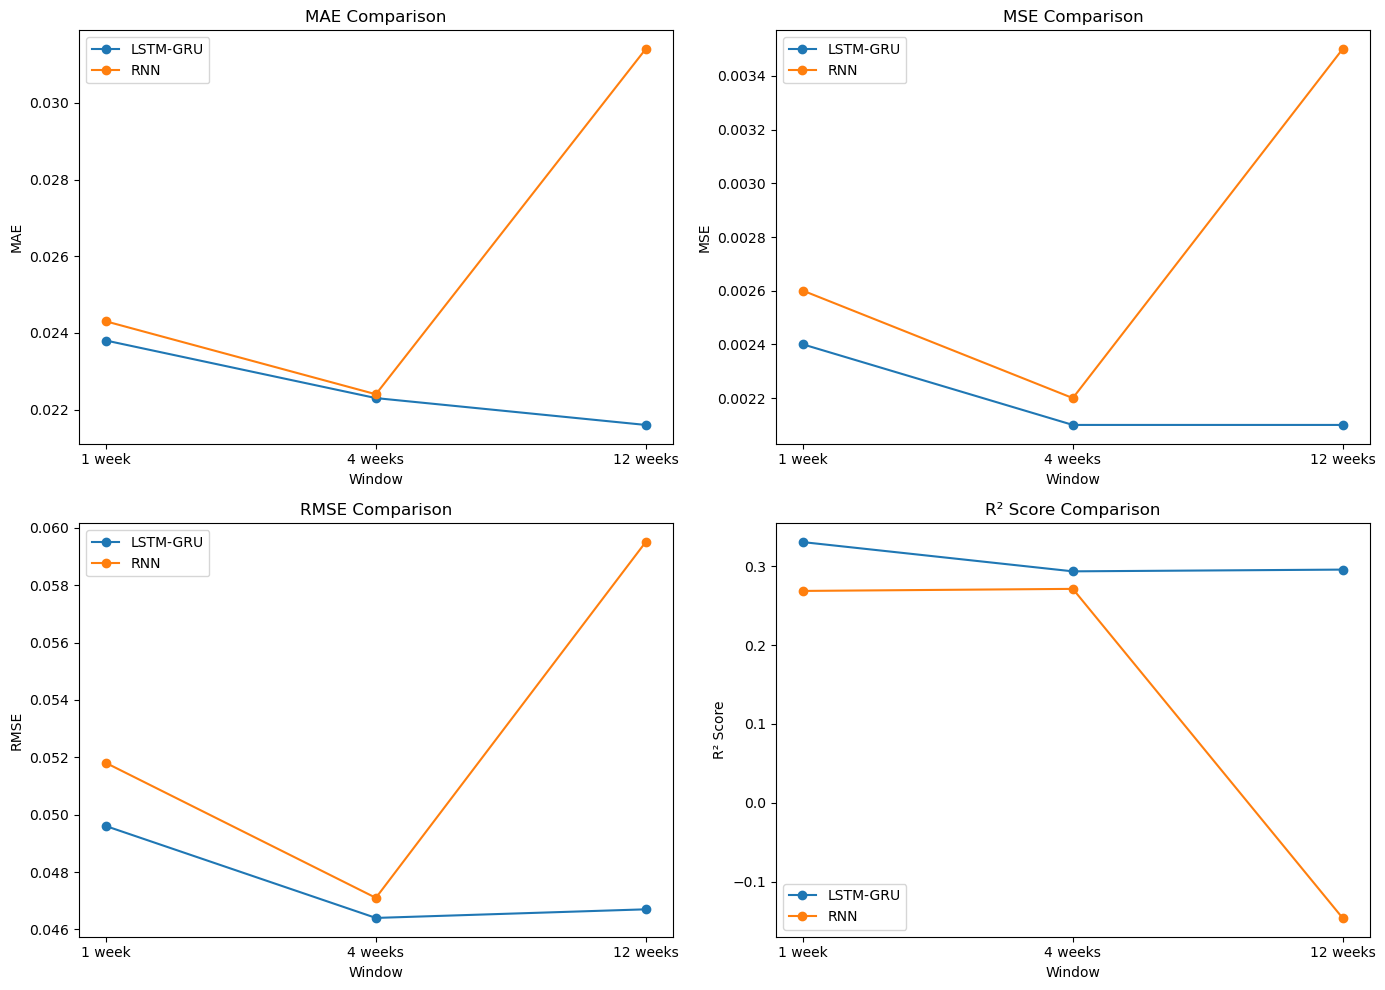

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
windows = ['1 week', '4 weeks', '12 weeks']

# LSTM-GRU model results
lstm_gru_mae = [0.0238, 0.0223, 0.0216]
lstm_gru_mse = [0.0024, 0.0021, 0.0021]
lstm_gru_rmse = [0.0496, 0.0464, 0.0467]
lstm_gru_r2 = [0.3303, 0.2933, 0.2955]

# RNN model results
rnn_mae = [0.0243, 0.0224, 0.0314]
rnn_mse = [0.0026, 0.0022, 0.0035]
rnn_rmse = [0.0518, 0.0471, 0.0595]
rnn_r2 = [0.2685, 0.2711, -0.1456]

# Define plot size
plt.figure(figsize=(14, 10))

# Plot MAE
plt.subplot(2, 2, 1)
plt.plot(windows, lstm_gru_mae, label='LSTM-GRU', marker='o')
plt.plot(windows, rnn_mae, label='RNN', marker='o')
plt.title('MAE Comparison')
plt.xlabel('Window')
plt.ylabel('MAE')
plt.legend()

# Plot MSE
plt.subplot(2, 2, 2)
plt.plot(windows, lstm_gru_mse, label='LSTM-GRU', marker='o')
plt.plot(windows, rnn_mse, label='RNN', marker='o')
plt.title('MSE Comparison')
plt.xlabel('Window')
plt.ylabel('MSE')
plt.legend()

# Plot RMSE
plt.subplot(2, 2, 3)
plt.plot(windows, lstm_gru_rmse, label='LSTM-GRU', marker='o')
plt.plot(windows, rnn_rmse, label='RNN', marker='o')
plt.title('RMSE Comparison')
plt.xlabel('Window')
plt.ylabel('RMSE')
plt.legend()

# Plot R² Score
plt.subplot(2, 2, 4)
plt.plot(windows, lstm_gru_r2, label='LSTM-GRU', marker='o')
plt.plot(windows, rnn_r2, label='RNN', marker='o')
plt.title('R² Score Comparison')
plt.xlabel('Window')
plt.ylabel('R² Score')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure as a TIFF file
plt.savefig('comparison_plots.tiff', format='tiff')

# Show plot
plt.show()


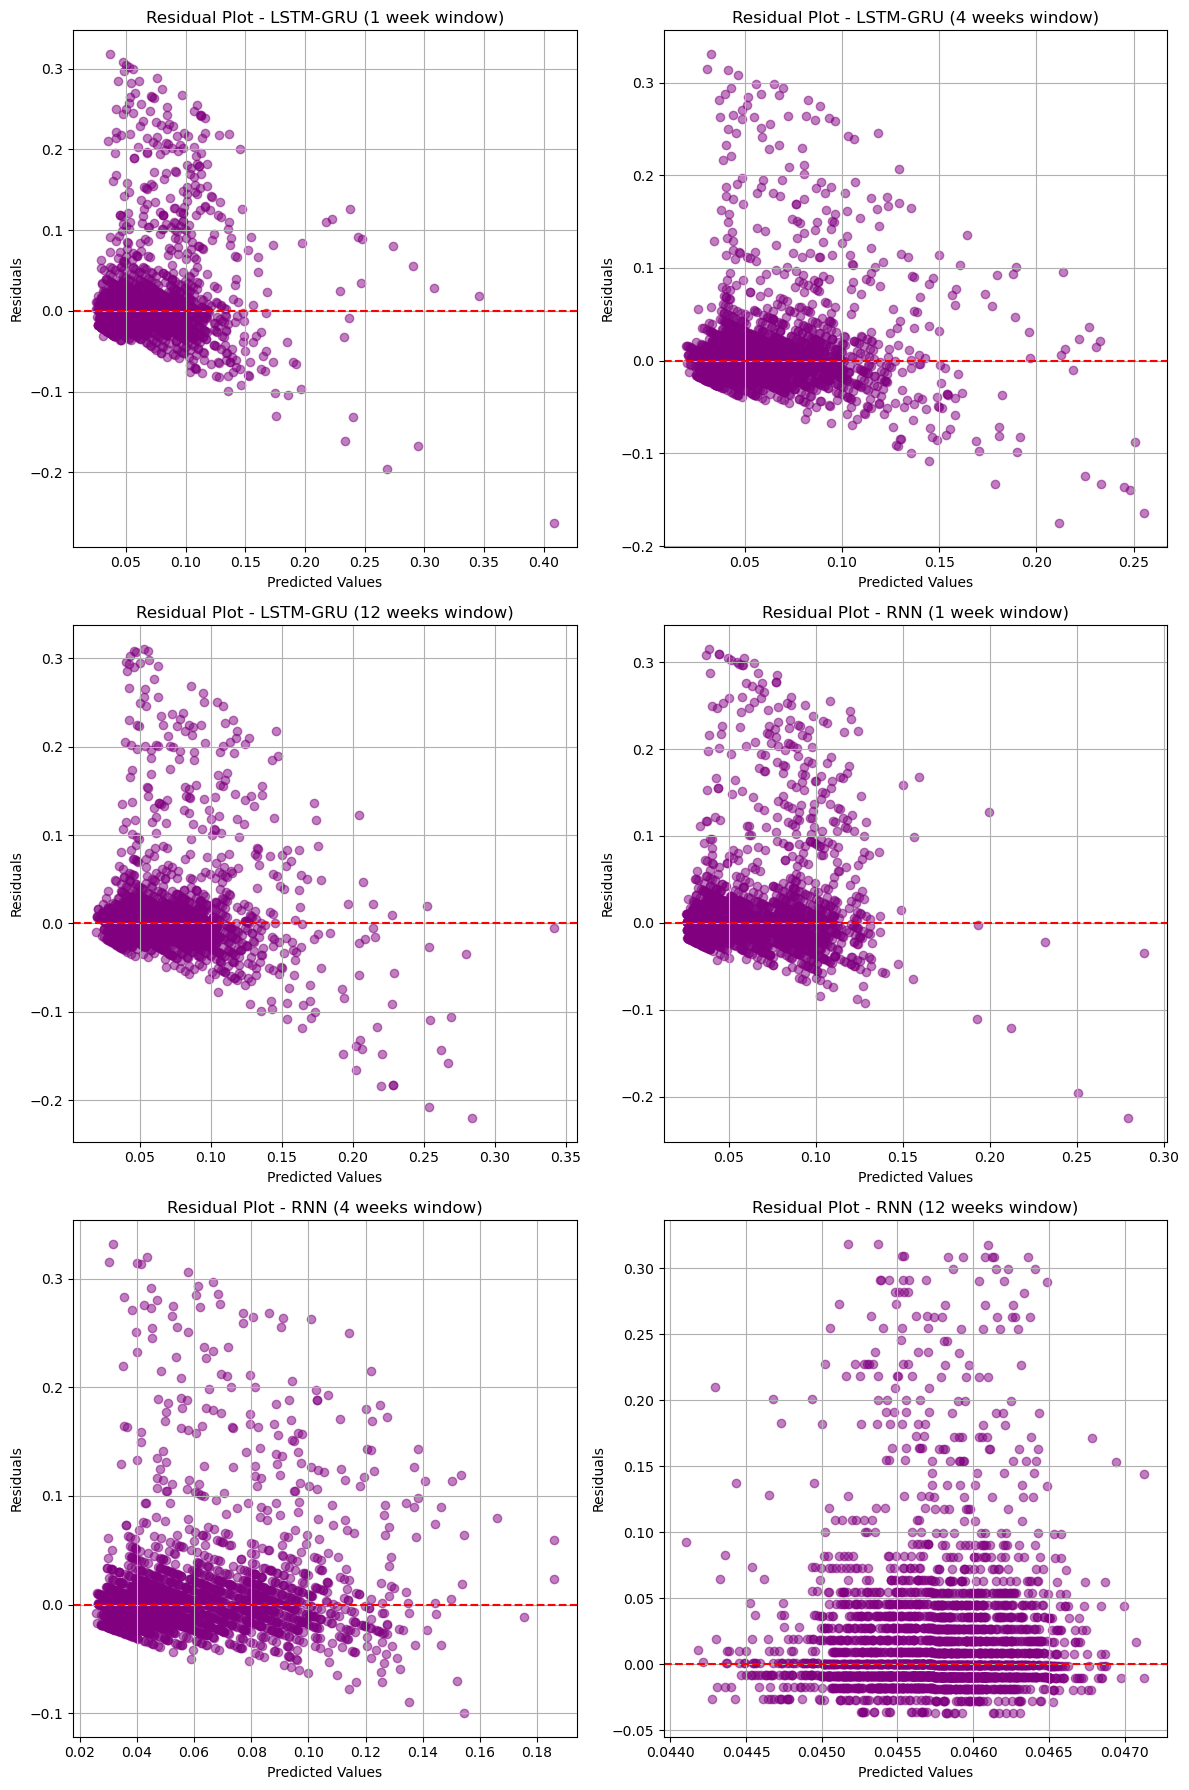

In [15]:
import matplotlib.pyplot as plt

def plot_residuals_grid(actual_predictions_lstm_gru, actual_predictions_rnn):
    # Calculate the total number of plots
    total_plots = len(actual_predictions_lstm_gru) + len(actual_predictions_rnn)
    # Calculate the number of rows and columns for the grid
    cols = 2  # Let's assume we want 2 columns
    rows = (total_plots + cols - 1) // cols  # Calculate rows needed

    # Create a figure with the appropriate number of subplots
    fig, axs = plt.subplots(rows, cols, figsize=(12, rows * 6))
    axs = axs.flatten()  # Flatten the array to easily index it

    plot_index = 0

    # Plot residuals for LSTM-GRU model
    for window_name, predictions in actual_predictions_lstm_gru.items():
        residuals = predictions['actual'] - predictions['predicted']
        axs[plot_index].scatter(predictions['predicted'], residuals, alpha=0.5, color='purple')
        axs[plot_index].axhline(y=0, color='red', linestyle='--')
        axs[plot_index].set_title(f'Residual Plot - LSTM-GRU ({window_name} window)')
        axs[plot_index].set_xlabel('Predicted Values')
        axs[plot_index].set_ylabel('Residuals')
        axs[plot_index].grid(True)
        plot_index += 1

    # Plot residuals for RNN model
    for window_name, predictions in actual_predictions_rnn.items():
        residuals = predictions['actual'] - predictions['predicted']
        axs[plot_index].scatter(predictions['predicted'], residuals, alpha=0.5, color='purple')
        axs[plot_index].axhline(y=0, color='red', linestyle='--')
        axs[plot_index].set_title(f'Residual Plot - RNN ({window_name} window)')
        axs[plot_index].set_xlabel('Predicted Values')
        axs[plot_index].set_ylabel('Residuals')
        axs[plot_index].grid(True)
        plot_index += 1

    # Adjust layout
    plt.tight_layout()
    
    # Save the figure as a TIFF file
    plt.savefig('residuals_grid.tiff', format='tiff')
    
    # Show the plot
    plt.show()

# Assuming actual_predictions_lstm_gru and actual_predictions_rnn are your dictionaries with predictions
plot_residuals_grid(actual_predictions_lstm_gru, actual_predictions_rnn)


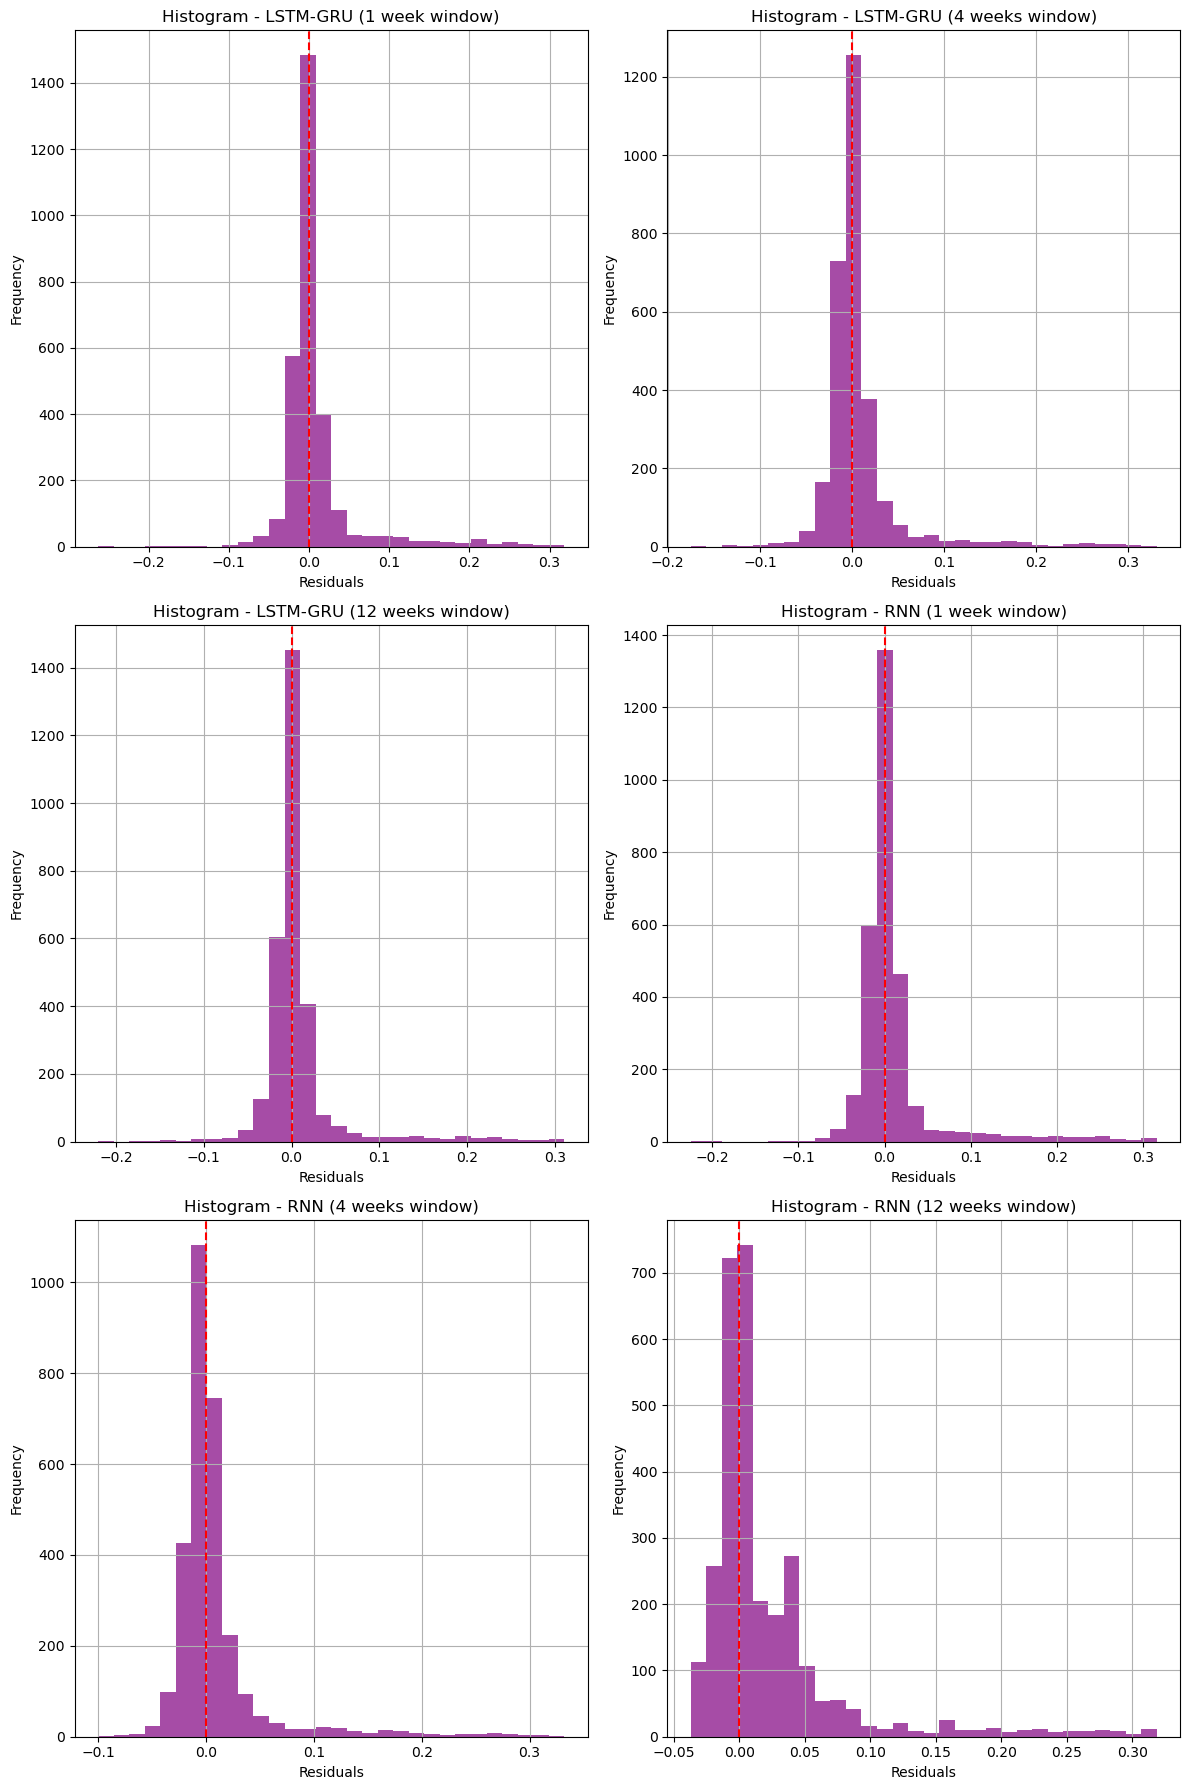

In [16]:
import matplotlib.pyplot as plt

def plot_residuals_histogram(actual_predictions_lstm_gru, actual_predictions_rnn):
    # Calculate the total number of plots
    total_plots = len(actual_predictions_lstm_gru) + len(actual_predictions_rnn)
    # Calculate the number of rows and columns for the grid
    cols = 2  # We want 2 columns for histograms
    rows = (total_plots + cols - 1) // cols  # Calculate rows needed

    # Create a figure with the appropriate number of subplots
    fig, axs = plt.subplots(rows, cols, figsize=(12, rows * 6))
    axs = axs.flatten()  # Flatten the array to easily index it

    plot_index = 0

    def plot_histogram(ax, residuals, title):
        ax.hist(residuals, bins=30, alpha=0.7, color='purple')
        ax.axvline(x=0, color='red', linestyle='--')
        ax.set_title(title)
        ax.set_xlabel('Residuals')
        ax.set_ylabel('Frequency')
        ax.grid(True)

    # Plot histograms for LSTM-GRU model
    for window_name, predictions in actual_predictions_lstm_gru.items():
        residuals = predictions['actual'] - predictions['predicted']
        plot_histogram(axs[plot_index], residuals, f'Histogram - LSTM-GRU ({window_name} window)')
        plot_index += 1

    # Plot histograms for RNN model
    for window_name, predictions in actual_predictions_rnn.items():
        residuals = predictions['actual'] - predictions['predicted']
        plot_histogram(axs[plot_index], residuals, f'Histogram - RNN ({window_name} window)')
        plot_index += 1

    # Adjust layout
    plt.tight_layout()
    
    # Save the figure as a TIFF file
    plt.savefig('residuals_histogram.tiff', format='tiff')
    
    # Show the plot
    plt.show()

# Assuming actual_predictions_lstm_gru and actual_predictions_rnn are your dictionaries with predictions
plot_residuals_histogram(actual_predictions_lstm_gru, actual_predictions_rnn)


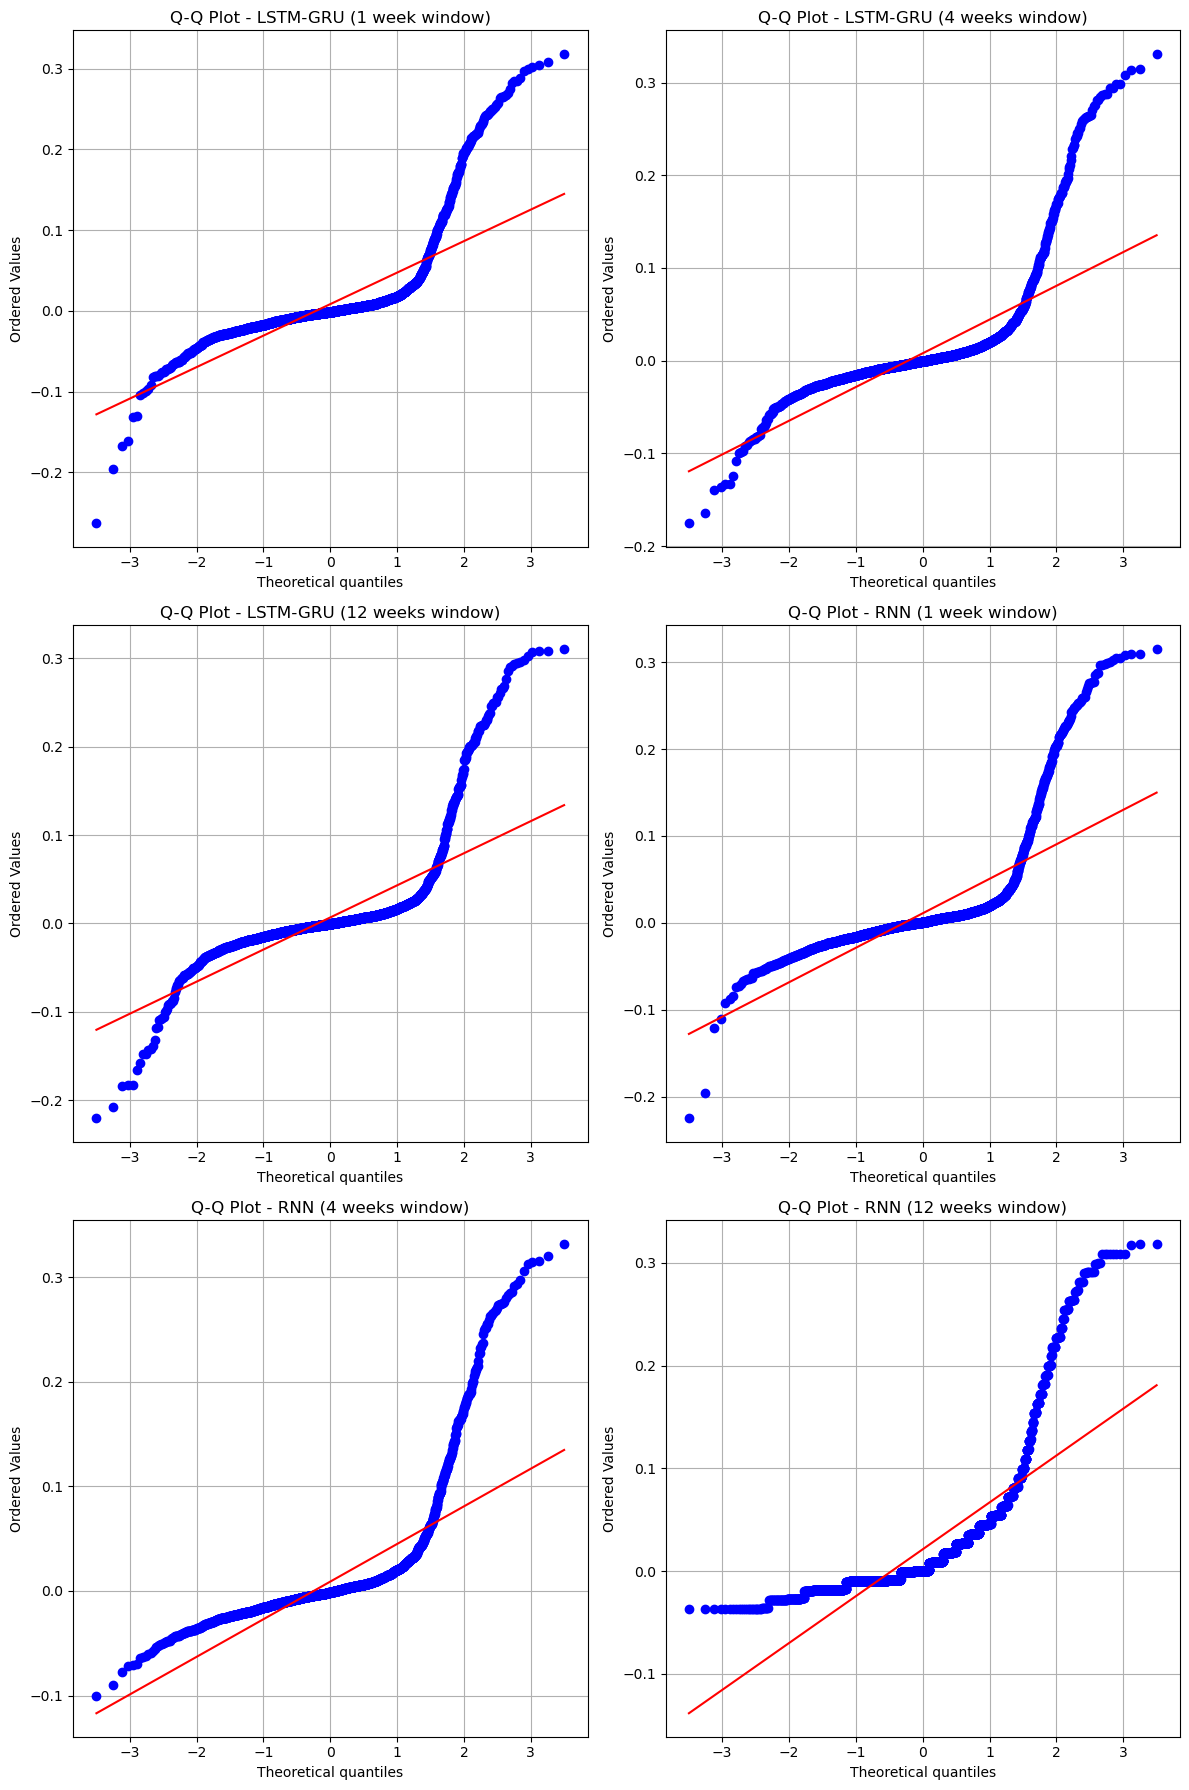

In [17]:
import scipy.stats as stats
import matplotlib.pyplot as plt

def plot_residuals_qq(actual_predictions_lstm_gru, actual_predictions_rnn):
    # Calculate the total number of plots
    total_plots = len(actual_predictions_lstm_gru) + len(actual_predictions_rnn)
    # Calculate the number of rows and columns for the grid
    cols = 2  # We want 2 columns for Q-Q plots
    rows = (total_plots + cols - 1) // cols  # Calculate rows needed

    # Create a figure with the appropriate number of subplots
    fig, axs = plt.subplots(rows, cols, figsize=(12, rows * 6))
    axs = axs.flatten()  # Flatten the array to easily index it

    plot_index = 0

    def plot_qq(ax, residuals, title):
        stats.probplot(residuals, dist="norm", plot=ax)
        ax.get_lines()[1].set_color('red')
        ax.set_title(title)
        ax.grid(True)

    # Plot Q-Q plots for LSTM-GRU model
    for window_name, predictions in actual_predictions_lstm_gru.items():
        residuals = predictions['actual'] - predictions['predicted']
        plot_qq(axs[plot_index], residuals, f'Q-Q Plot - LSTM-GRU ({window_name} window)')
        plot_index += 1

    # Plot Q-Q plots for RNN model
    for window_name, predictions in actual_predictions_rnn.items():
        residuals = predictions['actual'] - predictions['predicted']
        plot_qq(axs[plot_index], residuals, f'Q-Q Plot - RNN ({window_name} window)')
        plot_index += 1

    # Adjust layout
    plt.tight_layout()
    
    # Save the figure as a TIFF file
    plt.savefig('residuals_qq_plots.tiff', format='tiff')
    
    # Show the plot
    plt.show()

# Assuming actual_predictions_lstm_gru and actual_predictions_rnn are your dictionaries with predictions
plot_residuals_qq(actual_predictions_lstm_gru, actual_predictions_rnn)


C:\Users\Administrator\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Administrator\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Administrator\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Administrator\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

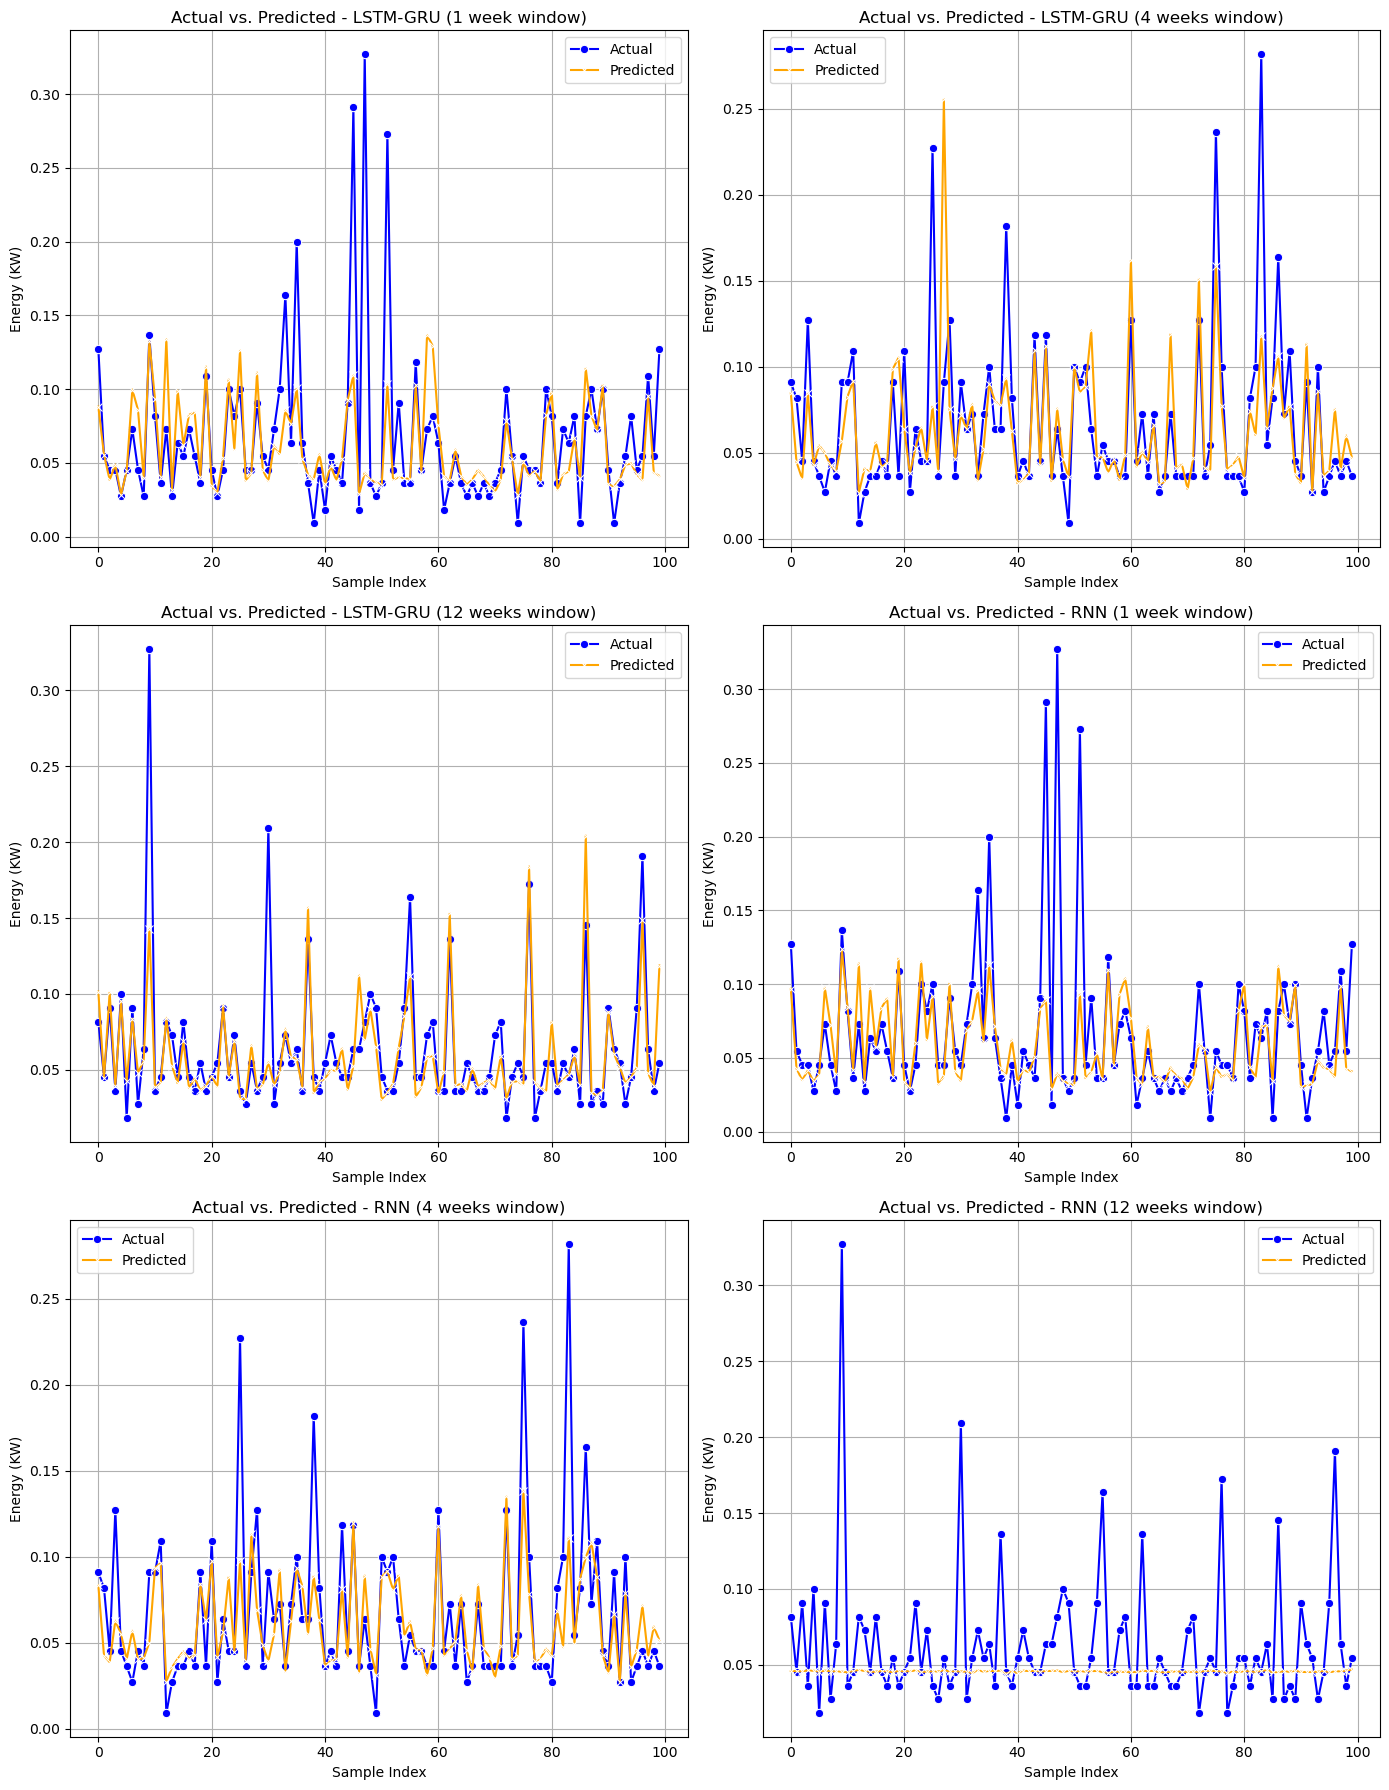

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_actual_vs_predicted_grid(actual_predictions_lstm_gru, actual_predictions_rnn):
    # Calculate the total number of plots
    total_plots = len(actual_predictions_lstm_gru) + len(actual_predictions_rnn)
    # Calculate the number of rows and columns for the grid
    cols = 2  # Let's assume we want 2 columns
    rows = (total_plots + cols - 1) // cols  # Calculate rows needed

    # Create a figure with the appropriate number of subplots
    fig, axs = plt.subplots(rows, cols, figsize=(14, rows * 6))
    axs = axs.flatten()  # Flatten the array to easily index it

    plot_index = 0

    def plot_actual_vs_predicted(ax, actual, predicted, model_name, window_name):
        sns.lineplot(x=range(100), y=actual[:100], label='Actual', color='blue', marker='o', ax=ax)
        sns.lineplot(x=range(100), y=predicted[:100], label='Predicted', color='orange', marker='x', ax=ax)
        ax.set_title(f'Actual vs. Predicted - {model_name} ({window_name} window)')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('Energy (KW)')
        ax.legend()
        ax.grid(True)

    # Plot actual vs. predicted values for LSTM-GRU model
    for window_name, predictions in actual_predictions_lstm_gru.items():
        plot_actual_vs_predicted(axs[plot_index], predictions['actual'], predictions['predicted'], 'LSTM-GRU', window_name)
        plot_index += 1

    # Plot actual vs. predicted values for RNN model
    for window_name, predictions in actual_predictions_rnn.items():
        plot_actual_vs_predicted(axs[plot_index], predictions['actual'], predictions['predicted'], 'RNN', window_name)
        plot_index += 1

    # Adjust layout
    plt.tight_layout()
    
    # Save the figure as a TIFF file
    plt.savefig('actual_vs_predicted.tiff', format='tiff')
    
    # Show the plot
    plt.show()

# Assuming actual_predictions_lstm_gru and actual_predictions_rnn are your dictionaries with predictions
plot_actual_vs_predicted_grid(actual_predictions_lstm_gru, actual_predictions_rnn)
